In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate

import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

size=12
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 5,
          'lines.linewidth': 2,
          'figure.dpi': 80}
plt.rcParams.update(params)

In [2]:
inf = float('Inf')

def hill(x,k,n, A = 1.):
    if n == float('Inf'):
        return A*step_function(np.abs(x),k)
    return A*k**n/(k**n + x**n)

def step_function(x, k):
    return np.array(x<k)

def kymograph(m, ax = None):
    if ax is None:
        plt.figure() ## can specify figsize=(width,height)
        ax = plt.gca()
    ax.imshow(m, cmap = cmap, origin = 'lower')
    # ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    return ax

def stripe_plot(array, title='', xlabel='', vmin=None, vmax=None):
    plt.imshow(np.ones((20, len(array)))*array, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.yticks((0,))
    plt.xlabel(xlabel)
    plt.ylabel(' ')
    plt.show()
    
def pattern_plots(phi, dphi, tb_loc, t, delta_star=2*np.pi):
    pattern = phi[:, -1]
    
    segmented = np.abs(dphi) > delta_star
    front_loc_end = np.where(segmented[:, -1])[0][0]
    front_time_start = np.min(np.where(segmented)[1])
    
    pattern2 = pattern[front_loc_end:] - pattern[-1]
    add_x = (xmax-front_loc_end)*(1./(1 - front_time_start/len(t)) - 1.)
    pattern2 = np.concatenate((pattern2, np.nan*np.ones(int(add_x))))
    stripe_plot(np.cos(pattern2[::-1]), title='Stripes, aligned with t of formation', xlabel='x')
    blocs = pattern2[::-1]//(2*np.pi) # floor division
    blocs_size = np.zeros(len(blocs))
    for b in np.unique(blocs):
        blocs_size[blocs == b] = np.sum(blocs==b)
    blocs_size/=np.nanmean(blocs_size)
    blocs_size[blocs_size==0] = np.nan
    stripe_plot(blocs, 'Segment number', xlabel='x')
    stripe_plot(blocs_size, 'Segment size', xlabel='x')
    
    ## Uncomment this if you want to also plot the pattern aligned with
    ## the reference oscillation at the time the cells where born:
    
    # pattern1 = pattern.copy()
    # pattern1[:front_loc_end] = 0.
    # add_x = xmax*(len(t)/(len(t)-np.sum(tb_loc==0)) - 1.)
    # pattern1 = np.concatenate((np.nan*np.ones(int(add_x)), pattern1))
    # stripe_plot(np.cos(pattern1[::-1]), title='Stripes, aligned with t of cell birth', xlabel='x')
    # stripe_plot(pattern1[::-1]//(2*np.pi), xlabel='x')

In [3]:
## function for integration (RHS)
def f(t, phi, omega, alpha, v, x0, epsilon, delta_star, hill_coeff):
    dpdt = np.zeros(len(phi))
    phi0 = phi[0]  ## the first element of the array ia always kept for the reference oscillator
    delta_phi = phi - phi0 
    tb_loc = int(x0 - v*t)
    if tb_loc>0: ## if tb is within the field of view
        ## PSM:
        dpdt[tb_loc:] = ((omega - epsilon + alpha*delta_phi) * hill(np.abs(delta_phi), delta_star, hill_coeff))[tb_loc:]
        #fantom cells before tb oscillate as reference:
        dpdt[:tb_loc] = omega
    else: ## tb is past the field of view
        ## all cells in PSM:
        dpdt = (omega - epsilon + alpha*delta_phi) * hill(np.abs(delta_phi), delta_star, hill_coeff)
        ## reference:
        dpdt[0] = omega
    return dpdt

## main function 
def alpha_model(xmax, init_cond, omega, alpha, v, x0, epsilon, delta_star=2.*np.pi, hill_coeff=inf, timesteps = 300, tmax = 120):
    phi_map = np.zeros((xmax, timesteps))
    dphi_map = np.zeros((xmax, timesteps))
    times = np.linspace(0, tmax, timesteps)
    if len(init_cond) == xmax:
        initial = np.zeros(xmax+1)
        initial[1:] = init_cond
    else:
        print('error in initial condition, using zeros')
        initial = np.zeros(xmax+1)
    ans = integrate.solve_ivp(f,[0.,tmax], initial, args = (omega, alpha, v, x0, epsilon, delta_star, hill_coeff),
                              dense_output = True, method = 'LSODA', rtol=1e-5, atol=1e-7)
    sol = ans.sol(times)
    phi0 = sol[0, :]
    phi_map = sol[1:, :]
    tb_locs = np.maximum(x0-v*times, np.zeros(len(times)))
    for it in range(timesteps):
        phi_map[:int(tb_locs[it]), it] = np.nan
    for x in range(xmax):
        dphi_map[x,:] = phi_map[x,:] - phi0
    return phi_map, dphi_map, phi0, tb_locs, times

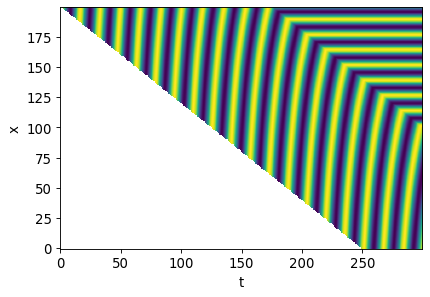

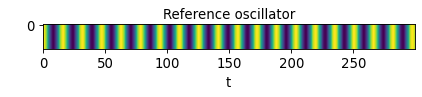

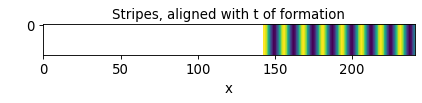

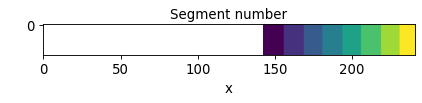

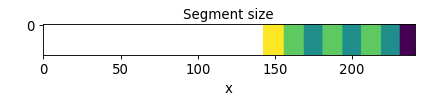

In [4]:
xmax = 200
init_cond = np.zeros(xmax)
omega = 1.
alpha = 0.02
v = 2.
x0 = xmax


phi, dphi, phi0, tb_loc, t = alpha_model(xmax, init_cond, omega=omega, alpha=alpha,
                                         v=v, x0=x0, epsilon=0.04)

kymograph(np.cos(phi))
plt.show()

stripe_plot(np.cos(phi0), title='Reference oscillator', xlabel='t')
pattern_plots(phi, dphi, tb_loc, t)


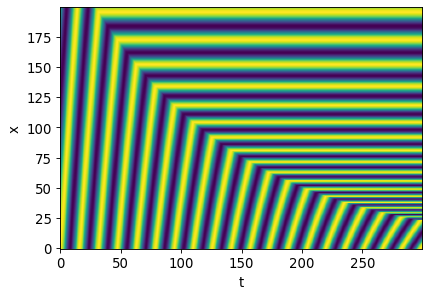

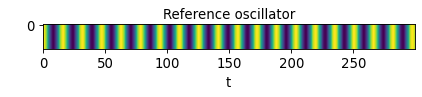

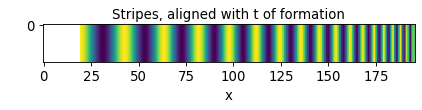

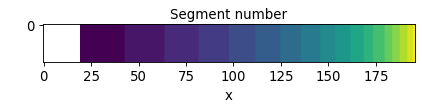

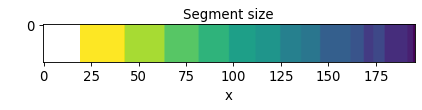

In [5]:
xmax = 200
init_cond = -0.025*np.arange(xmax)
omega = 1.
alpha = 0.02
v = 0.
x0 = 0


phi, dphi, phi0, tb_loc, t = alpha_model(xmax, init_cond, omega=omega, alpha=alpha,
                                         v=v, x0=x0, epsilon=0.)

kymograph(np.cos(phi))
plt.show()

stripe_plot(np.cos(phi0), title='Reference oscillator', xlabel='t')
pattern_plots(phi, dphi, tb_loc, t)



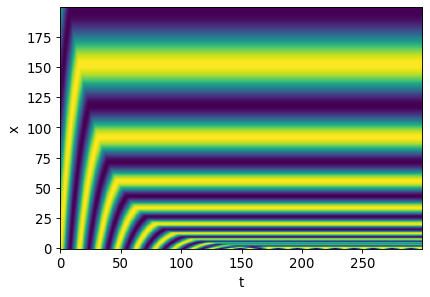

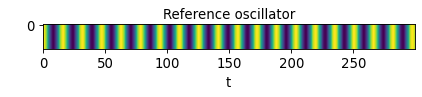

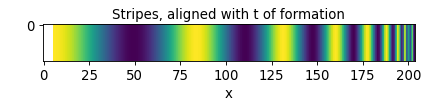

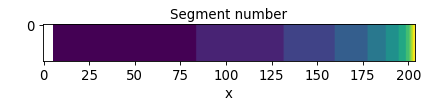

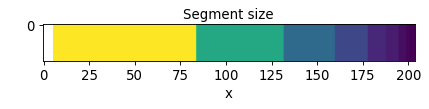

In [6]:
xmax = 200
init_cond = -0.025*np.arange(xmax)
omega = 1.
alpha = 0.08
v = 0.
x0 = 0


phi, dphi, phi0, tb_loc, t = alpha_model(xmax, init_cond, omega=omega, alpha=alpha,
                                         v=v, x0=x0, epsilon=0.)

kymograph(np.cos(phi))
plt.show()

stripe_plot(np.cos(phi0), title='Reference oscillator', xlabel='t')
pattern_plots(phi, dphi, tb_loc, t)

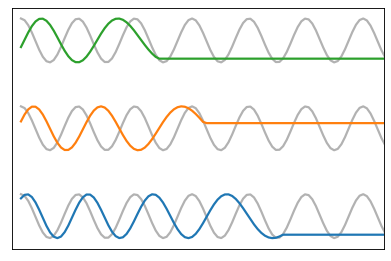

In [7]:
x = [0, 4, 8]
loc = [45, 60, 75]
loc = [25, 50, 75]
end = 100

for i in range(len(loc)):
    plt.plot(t, x[i]+np.cos(phi0), c='k', alpha=0.3)

    # plt.scatter(t, x[i]+np.cos(phi[loc[i]]),linestyle='-', c=(phi[loc[i]]-phi0)%(2*np.pi), cmap='twilight')
    plt.plot(t, x[i]+np.cos(phi[loc[i]]))

plt.xlim((-1, 40))
plt.xticks(())
plt.yticks(())

# plt.vlines(np.arange(7)*2*np.pi, -1.5, 9.5, lw= 1, colors='k', alpha=0.3)

plt.show()




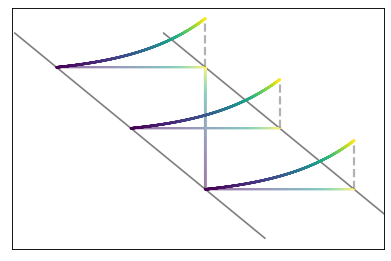

In [8]:
tmax = 5
times = np.linspace(0, tmax, 1000)
alpha = 0.4
A = 2.
deltaphi = A*(np.exp(alpha*times)-1.)/(np.exp(alpha*tmax)-1.)

times2 = np.linspace(-1.4, 7, 1000)
v=0.05

locs = [0,0.33*5, 0.66*5, 5]
locs = [0, 2.5, 5]

plt.plot(times2,-times2, c = 'k', alpha=0.5, lw=1.5)
plt.plot(times2+tmax,-times2, c = 'k', alpha=0.5, zorder=1, lw=1.5)
plt.vlines(5, -locs[-1], locs[0], colors='k', alpha = 0.3, zorder=0)

for x in locs:
    # plt.plot(times+x, -np.ones(len(times))*x, c='k', alpha = 0.3)
    plt.scatter(times+x, -np.ones(len(times))*x, s = 2, c=deltaphi, cmap='viridis', lw=.15, edgecolors='white', alpha=1)

    plt.plot((tmax+x, tmax+x), (-x, -x+A), '--', c='k', alpha = 0.3)
    plt.scatter(times+x, deltaphi-x, s = 5, c=deltaphi, cmap='viridis', zorder=10, lw=0)
plt.scatter(5*np.ones(len(deltaphi)), np.linspace(-locs[-1], locs[0], len(deltaphi)),
            s=3, c=deltaphi, cmap='viridis', zorder=1, alpha=1, lw=.15, edgecolors='white')
plt.xticks(())
plt.yticks(())

plt.xlim((-1.5,11))
plt.show()